In [1]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python3 --version

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/bin/python3 (found version "3.8.2") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/lisandro/Documents/mt/tp2
-- Configuring done
-- Generating done
-- Build files have b

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import metnum as mt
import os
import seaborn as sns
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold 

In [4]:
#percentage over total of train cases
PERCENTAGE_OF_TRAIN_CASES = 1
#neighbors for finding the mode in KNN
N_NEIGHBORS = 1
#components for PCA
N_COMPONENTS=40
#number of iterations to find eigenvalues and eigenvectors in power iteration
N_ITERATIONS=5000
#epsilon for power iteration
EPSILON=1e-10
#directory for saving matrix files
timestamp = datetime.now().strftime("%m_%d_%H_%M_%S")
DIRECTORY_NAME="{}".format(timestamp)
os.makedirs(DIRECTORY_NAME+"/", exist_ok=True)

%load_ext autoreload
%autoreload 2

df_train = pd.read_csv("../data/train.csv")

TOTAL_TRAIN_CASES = int(PERCENTAGE_OF_TRAIN_CASES*len(df_train))

#shuffle the train cases.
df_train = df_train[0: TOTAL_TRAIN_CASES].sample(frac=1)

# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


In [4]:
#Individual Tests

clf = mt.KNNClassifier(N_NEIGHBORS)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
cohen = cohen_kappa_score(y_val, y_pred)

print(acc)
print(cohen)



0.8928571428571429
0.8800142840138079


## Experimentación 3-Fold cross-validation 

CPU times: user 6h 53min 23s, sys: 36.3 s, total: 6h 53min 59s
Wall time: 6h 52min 54s


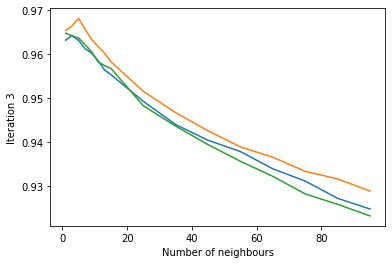

In [97]:
%%time
#3-Fold Cross validation

amount = X.shape[0] // k

list_acc = []

three_fold_df = {
    'Number of neighbours':[1,3,5,7,9,11,13,15,25,35,45,55,65,75,85,95]
}

N_NEIGHBORS = 1

accuracie_1 = []
accuracie_2 = []
accuracie_3 = []

while N_NEIGHBORS < 100:
    
    for i in range (3):
    
        X_train, y_train = np.concatenate((X[0:amount*i],X[amount * (i+1):])), np.concatenate((y[0:amount*i],y[amount * (i+1):]))
        X_val, y_val = X[amount*i:amount*(i+1)], y[amount*i:amount*(i+1)]
    
        clf = mt.KNNClassifier(N_NEIGHBORS)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        
        acc = accuracy_score(y_val, y_pred)
        
        if(i == 0):
            accuracie_1.append(acc)
        elif(i == 1):
            accuracie_2.append(acc)
        else:
            accuracie_3.append(acc)
            
    if(N_NEIGHBORS < 15):
        N_NEIGHBORS = N_NEIGHBORS + 2
    else:
        N_NEIGHBORS = N_NEIGHBORS + 10
            
three_fold_df.setdefault('Iteration 1',accuracie_1)
three_fold_df.setdefault('Iteration 2',accuracie_2)
three_fold_df.setdefault('Iteration 3',accuracie_3)

dfff = pd.DataFrame(three_fold_df)
dfff.to_csv("3_fold")

sns.lineplot(data = dfff, x = 'Number of neighbours', y = "Iteration 1")
sns.lineplot(data = dfff, x = 'Number of neighbours', y = "Iteration 2")
sns.lineplot(data = dfff, x = 'Number of neighbours', y = "Iteration 3")

TypeError: unsupported operand type(s) for -: 'list' and 'list'

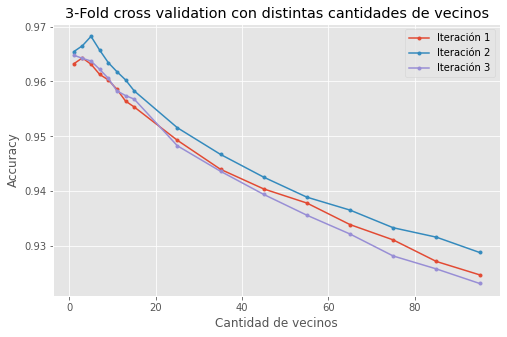

In [52]:
dfff = pd.read_csv('/home/lisandro/Documents/mt/tp2/notebooks/3_fold')

neibs = dfff['Number of neighbours'].to_list()

it1 = dfff['Iteration 1'].to_list()
it2 =  dfff['Iteration 2'].to_list()
it3 =  dfff['Iteration 3'].to_list()

plt.figure(figsize=(8,5))
plt.style.use('ggplot')
plt.plot(neibs, it1, marker = '.')
plt.plot(neibs, it2, marker = '.')
plt.plot(neibs, it3, marker = '.')
plt.xlabel('Cantidad de vecinos')
plt.ylabel('Accuracy')
plt.title('3-Fold cross validation con distintas cantidades de vecinos')
plt.legend(['Iteración 1', 'Iteración 2', 'Iteración 3'])
plt.savefig("3_fold_cross_validation_cant_vecinos.jpg")

In [65]:
sum = 0

for x in range (16):
    sum = sum + abs(it1[x]-it2[x])
    
sum = sum / 16   

print(sum)

suma = 0

for x in range (16):
    suma = suma + abs(it1[x]-it3[x])**2
    
suma = suma / 16 

print(suma)

sumb = 0

for x in range (16):
    sumb = sumb + abs(it3[x]-it2[x])**2
    
sumb = sumb / 16 

print(sumb)




0.003040178571428548
1.8577806122448923e-06
1.3788584183673533e-05
